In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from ipynb.fs.full.utility_functions import gen_data_dict, get_data, error_count, opart, SquaredHingeLoss, show_error_rate, plot_feature_targets
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
np.random.seed(123)
torch.manual_seed(123)

In [2]:
# target
target_df_1 = pd.read_csv('1_genome/1_training_data/target_lambda_fold1_base_e.csv')
target_df_2 = pd.read_csv('1_genome/1_training_data/target_lambda_fold2_base_e.csv')

targets_low_1  = torch.FloatTensor(target_df_1.iloc[:, 1:2].to_numpy())
targets_high_1 = torch.FloatTensor(target_df_1.iloc[:, 2:3].to_numpy())
targets_low_2  = torch.FloatTensor(target_df_2.iloc[:, 1:2].to_numpy())
targets_high_2 = torch.FloatTensor(target_df_2.iloc[:, 2:3].to_numpy())

y1_raw = torch.cat((targets_low_1, targets_high_1), dim=1)
y2_raw = torch.cat((targets_low_2, targets_high_2), dim=1)

In [3]:
# data
data = pd.read_csv('1_genome/1_training_data/seq_features.csv')['count'].to_numpy()
data = np.log(np.log(data)).reshape(-1,1)
X = torch.FloatTensor(data)

In [4]:
# filter
X1 = X
y1 = torch.mean(y1_raw, axis=1).reshape(-1,1)

X2 = X
y2 = torch.mean(y2_raw, axis=1).reshape(-1,1)

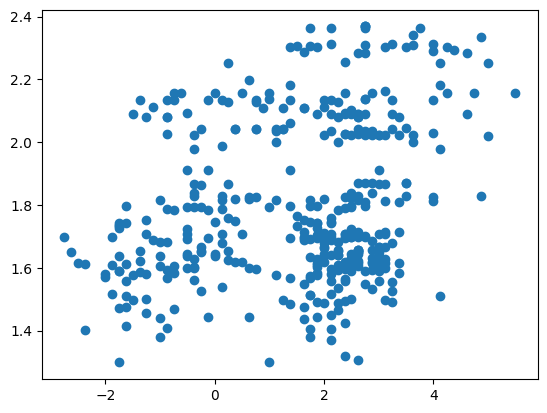

In [25]:
plt.scatter(y1.numpy(), X.numpy())
plt.show()

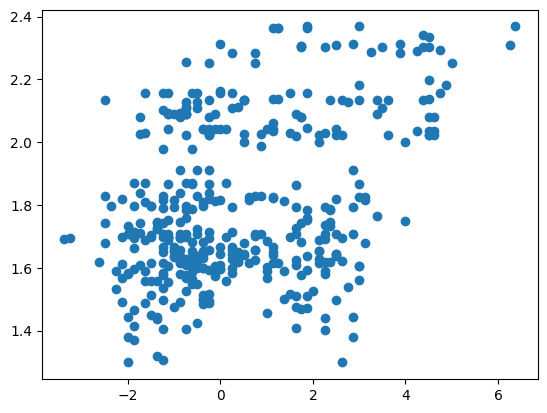

In [26]:
plt.scatter(y2.numpy(), X.numpy())
plt.show()

In [5]:
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.fc1(x)

In [6]:
def cv_learn(X1, X2, y1, y2):
    # Define the number of folds for cross-validation
    kf = KFold(n_splits=2, shuffle=True, random_state=123)

    # loss function
    squared_hinge_loss = SquaredHingeLoss(margin=1, low_lim=-7, high_lim=7)

    # learn best ite from fold 1
    best_ites_1 = []
    for train_index, val_index in kf.split(X1):
        # Split the data into training and validation sets
        X1_train_tensor, X1_val_tensor = X1[train_index], X1[val_index]
        y1_train_tensor, y1_val_tensor = y1[train_index], y1[val_index]

        # Define your model, loss, and optimizer
        model1 = LinearModel(input_size=1)
        optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

        # Training loop for the specified number of iterations
        val_losses_1 = []
        for _ in range(5000):
            loss1      = squared_hinge_loss(model1(X1_train_tensor), y1_train_tensor)
            val_loss_1 = squared_hinge_loss(model1(X1_val_tensor),   y1_val_tensor)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

            val_losses_1.append(val_loss_1.item())
        
        best_ite_1 = np.argmin(val_losses_1) + 1
        best_ites_1.append(best_ite_1)

    # learn best ite from fold 2
    best_ites_2 = []
    for train_index, val_index in kf.split(X2):
        # Split the data into training and validation sets
        X2_train_tensor, X2_val_tensor = X2[train_index], X2[val_index]
        y2_train_tensor, y2_val_tensor = y2[train_index], y2[val_index]

        # Define your model, loss, and optimizer
        model2 = LinearModel(input_size=1)
        optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

        # Training loop for the specified number of iterations
        val_losses_2 = []
        for _ in range(5000):
            loss2      = squared_hinge_loss(model2(X2_train_tensor), y2_train_tensor)
            val_loss_2 = squared_hinge_loss(model2(X2_val_tensor),   y2_val_tensor)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

            val_losses_2.append(val_loss_2.item())
        
        best_ite_2 = np.argmin(val_losses_2) + 1
        best_ites_2.append(best_ite_2)

    best_no_ite_1 = int(np.mean(best_ites_1))
    best_no_ite_2 = int(np.mean(best_ites_2))
    
    return best_no_ite_1, best_no_ite_2

In [7]:
def train_model(X, y, n_ites):
    model = LinearModel(input_size=1)
    loss_func = torch.nn.MSELoss()
    # squared_hinge_loss = SquaredHingeLoss(margin=1, low_lim=-7, high_lim=7)
    # squared_hinge_loss = SquaredHingeLoss(margin=0, low_lim=-7, high_lim=7)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for _ in range(n_ites):
        # Forward pass
        outputs = model(X)
        
        # Compute the custom loss
        loss = loss_func(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return model

In [8]:
def get_df_stat(ldas1, ldas2, seqs, labels):
    header = ['sequenceID', 'log_lambda_test_fold1', 'log_lambda_test_fold2', 'target_1', 'target_2', 'fold_1_total_labels', 'fold_2_total_labels', 'fold_1_fp_errs', 'fold_1_fn_errs', 'fold_1_tp', 'fold_1_tn', 'fold_2_fp_errs', 'fold_2_fn_errs', 'fold_2_tp', 'fold_2_tn']
    rows = []
    for i in range(len(seqs)):
        # generate data
        sequence, neg_start_1, neg_end_1, pos_start_1, pos_end_1, neg_start_2, neg_end_2, pos_start_2, pos_end_2 = get_data(i, seqs=seqs, labels=labels)

        # get total labels
        fold1_total_labels = len(neg_start_1) + len(pos_start_1)
        fold2_total_labels = len(neg_start_2) + len(pos_start_2)

        # run each lambda and record it into csv file
        row  = [seqs[i][0], ldas2[i], ldas1[i], list(y1_raw[i].numpy()), list(y2_raw[i].numpy()), fold1_total_labels, fold2_total_labels]

        # chpnt_fold1 = opart(np.exp(ldas2[i]), sequence)
        # chpnt_fold2 = opart(np.exp(ldas1[i]), sequence)

        chpnt_fold1 = opart(np.exp(ldas1[i]), sequence)
        chpnt_fold2 = opart(np.exp(ldas2[i]), sequence)

        err_1 = error_count(chpnt_fold1, neg_start_1, neg_end_1, pos_start_1, pos_end_1)
        err_2 = error_count(chpnt_fold2, neg_start_2, neg_end_2, pos_start_2, pos_end_2)
        
        for err in [err_1, err_2]:
            row.extend(err[:4])

        rows.append(row)
    
    df = pd.DataFrame(rows, columns=header)
    return df

In [9]:
def try_model(X1, X2, y1, y2):
    # best_no_ite_1, best_no_ite_2 = cv_learn(X, y1, y2)
    # print(best_no_ite_1, best_no_ite_2)

    # model1 = train_model(X, y1, best_no_ite_1)
    # model2 = train_model(X, y2, best_no_ite_2)

    model1 = train_model(X1, y1, 10000)
    model2 = train_model(X2, y2, 10000)

    # torch.save(model1.state_dict(), '1_genome/3_learned_models/1_linear/model1.pth')
    # torch.save(model2.state_dict(), '1_genome/3_learned_models/1_linear/model2.pth')

    with torch.no_grad():
        ldas1 = model1(X).numpy().reshape(-1)
        ldas2 = model2(X).numpy().reshape(-1)

    seqs   = gen_data_dict('1_genome/0_sequences_labels/signals.gz')
    labels = gen_data_dict('1_genome/0_sequences_labels/labels.gz')
    df = get_df_stat(ldas1, ldas2, seqs, labels)

    return df

In [10]:
df = try_model(X1, X2, y1, y2)

In [12]:
df.to_csv('1_genome/2_learning_record/linear_MSE_no_filter.csv', index=False)

In [13]:
df = pd.read_csv('1_genome/2_learning_record/linear_MSE_no_filter.csv')

In [18]:
show_error_rate(df)

(73.5372340425532, 71.53846153846153, 752, 520, 199, 148)

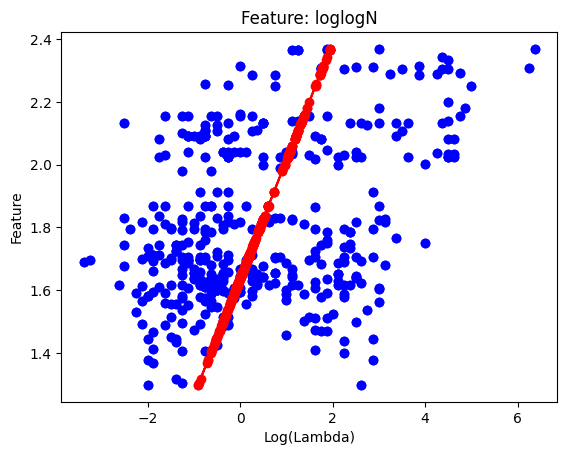

None


In [40]:
feature = X.numpy()
target  = y2.numpy()
predicted_target = df['log_lambda_test_fold1'].to_numpy()
print(plot_feature_targets(feature, target, target, predicted_target, 'loglogN'))

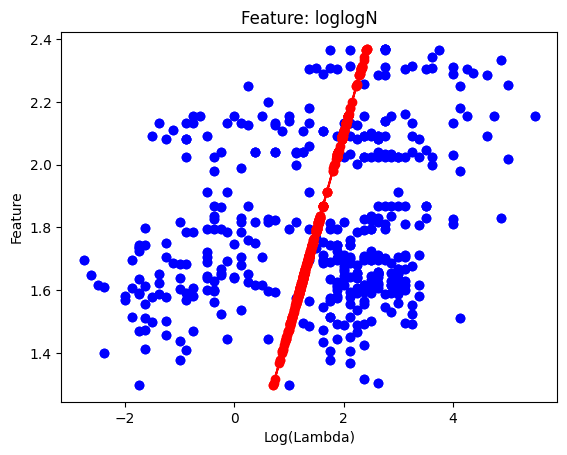

None


In [39]:
feature = X.numpy()
target  = y1.numpy()
predicted_target = df['log_lambda_test_fold2'].to_numpy()
print(plot_feature_targets(feature, target, target, predicted_target, 'loglogN'))